In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
import Hit_and_Run as hr
import phi_divergence as phi
from scipy.optimize import fsolve

In [1]:
def poly_cvar(p,alpha,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(1)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [1-s/l*(1-p) <= z]
    som = 0
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        som = som + l*f[i]*(1/p*(z[i]**(p/(p-1)))-1/p)
    constraints.append(som <= t)
    obj = cp.Maximize(theta_1+theta_2-t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)


def poly_cvar_neg(p,alpha,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    w = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [w == 1 - (1-p)*s/l, s <= 1/(1-p)]
    som = 0
    exp = p/(p-1)
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append(w[i]**exp <= t[i]*p/l + 1)
    obj = cp.Maximize(theta_1+theta_2- f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)


def kl_cvar(alpha,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append(cp.exp(s[i]/l)-1 <= t[i])
    obj = cp.Maximize(theta_1+theta_2-l*f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)
        
def cvar(alpha,x,f):
    eta = cp.Variable(1)
    dom = cp.Variable(1)
    constraints = [dom==1]
    n = len(x)
    som = 0
    for i in range(n):
        som = som + f[i]*cp.neg(x[i]+eta)
    obj = cp.Minimize(eta+1/alpha*som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(-prob.value)


def kl_cvar_port(alpha,R,l,f):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    s = cp.Variable(n)
    constraints = [cp.sum(a) == 1, a >= 0]
    X = R @ a
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        constraints.append(cp.exp(s[i]/l)-1 <= t[i])
    obj = cp.Maximize(theta_1+theta_2-l*f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

def poly_cvar_neg_port(p,alpha,R,f,l):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    w = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [cp.sum(a) == 1, a >= 0, w == 1 - (1-p)*s/l, s <= 1/(1-p)]
    som = 0
    exp = p/(p-1)
    X = R @ a
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        constraints.append(w[i]**exp <= t[i]*p/l + 1)
    obj = cp.Maximize(theta_1+theta_2- f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)


def cvar_port(alpha,R,f):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    eta = cp.Variable(1)
    constraints = [cp.sum(a) == 1, a >= 0]
    X = (R-r_f) @ a + r_f
    som = 0
    for i in range(n):
        som = som - f[i]*cp.pos(-1/alpha * X[i])
    obj = cp.Maximize(eta + som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

def poly_cvar_port_pos(p,alpha,x,f,l):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(1)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [cp.sum(a)==1, a>=0, 1-s/l*(1-p) <= z]
    X = R @ a
    som = 0
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        som = som + l*f[i]*(1/p*(z[i]**(p/(p-1)))-1/p)
    constraints.append(som <= t)
    obj = cp.Maximize(theta_1+theta_2-t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] > alpha:
        return(x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(1/alpha*(Ex+last))
    
def runif_in_simplex(n):
    k = np.random.exponential(scale=1.0, size=n)
    return k / sum(k)
        
    

In [3]:
####### lognormal models

def kl_cv_por_logn(alpha,R,l,f):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    s = cp.Variable(n)
    constraints = [cp.sum(a) == 1, a >= 0]
    X = R @ a
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        constraints.append(cp.exp(s[i]/l)-1 <= t[i])
    obj = cp.Maximize(theta_1+theta_2-l*f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

In [4]:
def kl_cvarl(alpha,x,f,l,lbd):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    for i in range(n):
        constraints.append(theta_1 + lbd*cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append(cp.exp(s[i]/l)-1 <= t[i])
    obj = cp.Maximize(theta_1+theta_2-l*f @ t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)

def poly_cvarl(p,alpha,x,f,l,lbd):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(1)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [1-s/l*(1-p) <= z]
    som = 0
    for i in range(n):
        constraints.append(theta_1 + lbd*cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        som = som + l*f[i]*(1/p*(z[i]**(p/(p-1)))-1/p)
    constraints.append(som <= t)
    obj = cp.Maximize(theta_1+theta_2-t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)

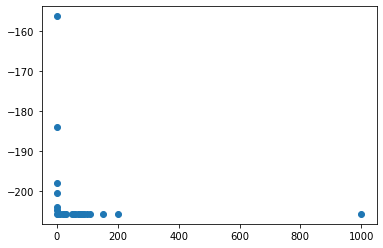

In [30]:
np.random.seed(12)
n = 100
f = np.zeros(n)+1/n
x = -(np.random.pareto(1,size = n)+1)
alpha=0.1
l=1
lbd = np.array([0.1,0.15,0.25,0.3,0.5,0.7,2,5,10,20,25,30,50,55,60,70,75,80,85,90,100,110,150,200,1000])
value = np.zeros(len(lbd))
i = 0
for l0 in lbd:
    value[i] = poly_cvarl(2,alpha,x,f,l,l0)
    i = i + 1
plt.plot(lbd, value, 'o')

In [39]:
np.random.seed(12)
n = 1000
f = np.zeros(n)+1/n
x = -((np.random.pareto(50,size = n)+1)*10000)
alpha=0.1
l=1
print(cvar(alpha,x,f))
print(kl_cvar(alpha,x,f,l))
print(poly_cvar(500,alpha,x,f,l))
#print(poly_cvar_neg(0.001,alpha,x,f,l))

-10697.848083569077
-11796.461610395578
-10704.191915536945


In [3]:
s = cp.Variable(2)

In [3]:
np.random.seed(12)
mean = np.array([0.2,-0.15,0.1,0.13,0.18])
cov_matrix = np.array([[1, -0.25, 0.25, 0, 0.25],[-0.25, 1, 0, 0.25, 0.25],[0.25, 0, 1, 0, 0.25],[0, 0.25, 0, 1, 0.5],[0.25, 0.25, 0.25, 0.5, 1]])
#b = np.random.random(size = (5,5))*2-1
#cov_matrix = b.dot(b.T)
cov_matrix

array([[ 1.  , -0.25,  0.25,  0.  ,  0.25],
       [-0.25,  1.  ,  0.  ,  0.25,  0.25],
       [ 0.25,  0.  ,  1.  ,  0.  ,  0.25],
       [ 0.  ,  0.25,  0.  ,  1.  ,  0.5 ],
       [ 0.25,  0.25,  0.25,  0.5 ,  1.  ]])

In [4]:
n = 3000
R = np.random.multivariate_normal(mean,cov_matrix,n)
alpha=0.05
f = np.zeros(n)+1/n
l = 1

In [119]:
wc_risk , wc_port = poly_cvar_port_pos(2,alpha,R,f,l)
print(wc_risk)
print(poly_cvar(2,alpha,R.dot(wc_port),f,l))
print(cvar_fast(alpha,R.dot(wc_port),f))

-1.3258753615573877
-1.3254476418240457
-1.3260607829032485


In [13]:
wc_risk , wc_port = poly_cvar_neg_port(0.3,alpha,R,f,l)
nom_risk, nom_port = cvar_port(alpha,R,f)
print(wc_risk)

-1.6540916079836365


In [5]:
wc_risk, wc_port = kl_cvar_port(alpha,R,l,f)
nom_risk, nom_port = cvar_port(alpha,R,f)
print(wc_risk)
print(nom_risk)

-1.5810634668972288
-1.022891597344445


In [7]:
kl_cvar(alpha,R.dot(nom_port),f,l)

-1.7032486804449407

In [11]:
prob3 = []
for i in range(30000):
    prob3.append(runif_in_simplex(n))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


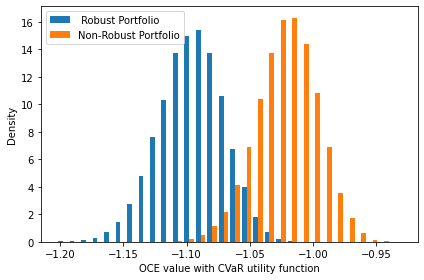

In [16]:
port_rob_risk = np.zeros(len(prob3))
port_nom_risk = np.zeros(len(prob3))
for i in range(len(prob3)):
    port_rob_risk[i] = cvar_fast(alpha,R.dot(wc_port),prob3[i])
    port_nom_risk[i] = cvar_fast(alpha,R.dot(nom_port),prob3[i])
data1 = {' Robust Portfolio':port_rob_risk, 'Non-Robust Portfolio': port_nom_risk}
dt1 = pd.DataFrame(data = data1)
plt.hist(dt1,density = True, bins = 30)
plt.ylabel('Density')
plt.xlabel('OCE value with CVaR utility function')
plt.legend(dt1.columns)
plt.tight_layout()
plt.savefig('CVaR_KL.eps', format = 'eps')

In [89]:
print(np.min(port_rob_risk))
print(np.min(port_nom_risk))

-1.7774510696116765
-1.7888691856720806


In [8]:
prob = []
N = R.shape[0]
mean = 1/n
var = np.sqrt(0.1/(n**2))
for i in range(20000):
    q_real = np.zeros(N)
    for j in range(N-1):
        continu = True
        while continu == True:
            q = np.random.normal(mean,var)
            if q>= 0:
                continu = False
                q_real[j] = q
    last = 1-np.sum(q_real[0:n-1])
    if last >= 0:
        q_real[n-1] = last
        prob.append(q_real)

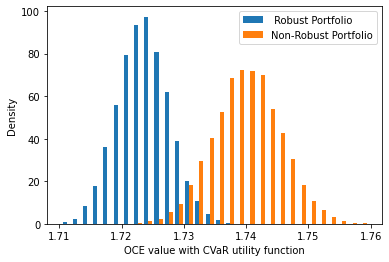

In [290]:
port_rob_risk = np.zeros(len(prob))
port_nom_risk = np.zeros(len(prob))
for i in range(len(prob)):
    port_rob_risk[i] = cvar_fast(alpha,R.dot(wc_port),prob[i])
    port_nom_risk[i] = cvar_fast(alpha,R.dot(nom_port),prob[i])
data1 = {' Robust Portfolio':port_rob_risk, 'Non-Robust Portfolio': port_nom_risk}
dt1 = pd.DataFrame(data = data1)
plt.hist(dt1,density = True, bins = 30)
plt.ylabel('Density')
plt.xlabel('OCE value with CVaR utility function')
plt.legend(dt1.columns)

In [291]:
print(cvar_fast(alpha,R.dot(wc_port),f))
print(cvar_fast(alpha,R.dot(nom_port),f))
      

1.7231577869837802
1.7393518919297388


In [228]:
prob2 = hr.hit_and_run(f,phi.kb_eva,1000,1,5000)

In [357]:
print(wc_port)
print(nom_port)

[1.32740802e-02 1.82721533e-10 2.68632462e-01 4.96527544e-01
 2.21565914e-01]
[2.33519051e-01 3.95830975e-12 6.54207190e-05 5.95074496e-01
 1.71341032e-01]


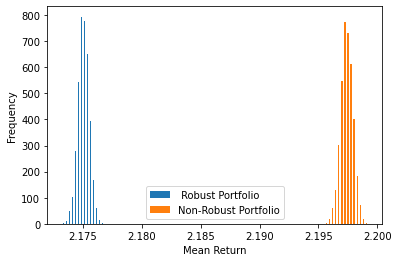

In [164]:
port_rob_return = np.zeros(len(prob))
port_nom_return = np.zeros(len(prob))
for i in range(len(prob)):
    port_rob_return[i] = np.sum(np.multiply(R.dot(wc_port),prob[i]))
    port_nom_return[i] = np.sum(np.multiply(R.dot(nom_port),prob[i]))
data1 = {' Robust Portfolio':port_rob_return, 'Non-Robust Portfolio': port_nom_return}
dt1 = pd.DataFrame(data = data1)
plt.hist(dt1,density = True, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Mean Return')
plt.legend(dt1.columns)

In [158]:
np.sum(np.multiply(R.dot(wc_port),prob[3]))
prob[3]

array([0.0010164 , 0.00102851, 0.00106954, 0.00096677, 0.00114055,
       0.00105774, 0.00097337, 0.00097999, 0.00100612, 0.0010016 ,
       0.00101585, 0.00089399, 0.00098499, 0.00095048, 0.0010187 ,
       0.00092122, 0.00104534, 0.00097121, 0.0009835 , 0.00110465,
       0.00109903, 0.00101556, 0.00110754, 0.001004  , 0.00105593,
       0.0009716 , 0.00103518, 0.00107191, 0.00093039, 0.00089766,
       0.00099844, 0.0009582 , 0.00106906, 0.00100818, 0.00086006,
       0.00105652, 0.00108419, 0.00082839, 0.00099613, 0.00122439,
       0.00096256, 0.00104751, 0.0009782 , 0.00102014, 0.00096217,
       0.00093402, 0.00104918, 0.0008976 , 0.00086847, 0.0010299 ,
       0.00095231, 0.0009692 , 0.00099657, 0.00095247, 0.00089845,
       0.00085487, 0.00103789, 0.00105529, 0.0010172 , 0.00093482,
       0.0009708 , 0.00095786, 0.00106933, 0.00097016, 0.00112424,
       0.00107041, 0.00092378, 0.00099009, 0.00102656, 0.00100358,
       0.00102664, 0.00096797, 0.00101047, 0.00104631, 0.00101

In [79]:
n = 1000
R = np.random.multivariate_normal(mean,cov_matrix,n)
alpha=0.05
f = np.zeros(n)+1/n
L = np.array([0.01,0.1,0.2,0.5,1,5,10,15,20,30,50,70,100,200])
wc_risk = np.zeros(len(L))
nom_risk = np.zeros(len(L))
i = 0 
for l in L:
    wc_risk[i], wc_port = kl_cvar_port(alpha,R,l,f)
    nom_risk[i] = cvar(alpha,R.dot(wc_port),f)
    i = i + 1

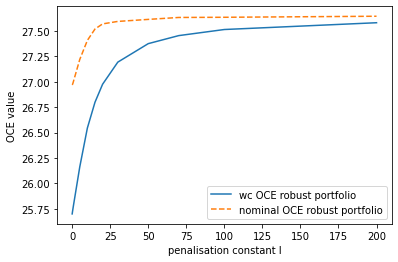

In [83]:
plt.plot(L,wc_risk, label = 'wc OCE robust portfolio')
plt.plot(L,nom_risk, '--', label = 'nominal OCE robust portfolio')
plt.xlabel('penalisation constant l')
plt.ylabel('OCE value')
plt.legend()
plt.savefig('klcvar.png', format = 'png')

In [3]:
def partial_pcvar(theta, p, x, alpha):
    arg_1 = theta[0] + 1/alpha * np.max(theta[1]-x,0)
    arg_2 = theta[1] + 1/alpha * (theta[1] - x)
    par1 = 0
    par2 = 0
    if arg_1 > 1/(1-p):
        par1 = (1+(p-1)*arg_1)**(1/(p-1))
    if theta[1] > x and arg_2 > 1/(1-p):
        par2 = 1/alpha * (1+(p-1)*arg_2)**(1/(p-1))
    return(par1, par2)

def partial_pexp(theta, p, x):
    arg = theta[0] + np.exp(theta[1]-x)-1
    par1 = 0
    par2 = 0
    if arg > 1/(1-p):
        par1 = (1+(p-1)*arg)**(1/(p-1))
        par2 = par1 * np.exp(theta[1]-x)
    return(par1, par2)

def d_pcvar_pos(theta, *data):
    p,X,alpha = data
    n = len(X)
    partial_1 = 0
    partial_2 = 0
    for i in range(n):
        par1, par2 = partial_pcvar(theta, p, X[i], alpha)
        partial_1 = partial_1 + par1
        partial_2 = partial_2 + par2
    return(1/n*partial_1-1, 1/n*partial_2-1)

def d_pexp_pos(theta, *data):
    p,X = data
    n = len(X)
    partial_1 = 0
    partial_2 = 0
    for i in range(n):
        par1, par2 = partial_pexp(theta, p, X[i])
        partial_1 = partial_1 + par1
        partial_2 = partial_2 + par2
    return(1/n*partial_1-1, 1/n*partial_2-1)

def poly(p,x):
    return((x**p-p*(x-1)-1)/(p*(p-1)))

def wc_pcvar(root,*data):
    p,X,alpha = data
    n = len(X)
    wc = 0
    for i in range(n):
        par1, par2 = partial_pcvar(root, p, X[i], alpha)
        if par1!= 0 and par2/par1 >1/alpha:
            return(np.infty)
        wc = wc + X[i]*par2+poly(p,par1)
    return(wc/n)

def wc_pexp(root,*data):
    p,X = data
    n = len(X)
    wc = 0
    for i in range(n):
        par1, par2 = partial_pexp(root, p, X[i])
        if par1 == 0:
            arg = X[i]*par2+poly(p,par1)
        else:
            frac = par2/par1
            arg = X[i]*par2+par1*(frac*np.log(frac)-frac+1)+poly(p,par1)
        wc = wc + arg
    return(wc/n)
    
        

In [10]:
np.random.seed(12)
n = 100
X = -(np.random.pareto(2,size = n)+1)
data = (1.8,X,0.05)
theta_0 = np.array([1,1])
root = fsolve(d_pcvar_pos, theta_0, args = data)
#root
print(d_pcvar_pos(root, *data))
print(wc_pcvar(root,*data))

(-4.474420833844306e-12, -1.1102230246251565e-15)
12.610218207461918


In [1]:
np.random.seed(12)
n = 1000
X = -2*np.random.weibull(1,size = n)
data = (1.01,X)
theta_0 = np.array([-407,-14.2])
root = fsolve(d_pexp_pos, theta_0, args = data)
print(root)
print(d_pexp_pos(root, *data))
print(wc_pexp(root,*data))

NameError: name 'np' is not defined

In [21]:
np.min(X)

-16.52455864851578

In [45]:
def expOCE(X):
    eta = cp.Variable(1)
    a = cp.Variable(1)
    n = len(X)
    constraints = [a == 1]
    som = 0
    for i in range(n):
        som = som + 1/n*(1-cp.exp(-X[i]+eta))
    obj = cp.Maximize(eta+som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value)
    
print(expOCE(X))
    

-9.938435712247697


In [89]:
np.mean(X)

-2.0841910294809916

In [117]:
f = np.zeros(n)+1/n
cvar_fast(0.05,X,f)

-7.185768752686754